## MonReader: Computer Vision Application to Classify Images

This project is about implementing a CNN algorithm that detects if the page of a book is flipped or non-flipped, using python

#### Background
MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

### Data Description:

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

### Goal(s):

* Predict if the page is being flipped using a single image.

### Success Metrics:

* Evaluate model performance based on F1 score, the higher the better.

### Bonus(es):

* Predict if a given sequence of images contains an action of flipping.

Import necessary libraries.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import os
import PIL
from PIL import Image
import splitfolders

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import *
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [38]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get and Split Dataset

Split the folders in the directory so there is a training folder, a validation folder and a testing folder.

In [7]:
os.chdir('C:\\Users\\Dorcas Taiwo\\Documents\\AI_Residency_Projects\\Project4\\sYK4raA4xabgaLi9\\data\\raw\\images\\')

In [8]:
## run just once
splitfolders.ratio('training', output='C:\\Users\\Dorcas Taiwo\\Documents\\AI_Residency_Projects\\Project4\\sYK4raA4xabgaLi9\\data\\raw\\images\\', ratio=(0.8, 0.2)) 

Firstly, in this part of the project, we will build a simple CNN (Convolutional Neural Network) to predict if a single image contains an action of flipping or not.

### Data augmentation

In [10]:
## Data transformation

train_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor()])

valid_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor()])

Loading the data from the directory and create Dataloaders.

In [11]:
## Load the data
data_dir = "C:\\Users\\Dorcas Taiwo\\Documents\\AI_Residency_Projects\\Project4\\sYK4raA4xabgaLi9\\data\\raw\\images\\"

d_train = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                               transform = train_transform)

d_val = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                               transform = valid_transform)

d_test = datasets.ImageFolder(os.path.join(data_dir, 'testing'),
                              transform = test_transform)



## DataLoaders
dl_train = DataLoader(dataset=d_train,
                batch_size=16,
                shuffle=True, 
                drop_last=False)

dl_valid = DataLoader(dataset=d_val,
                      batch_size=1,
                      shuffle=True)

dl_test = DataLoader(dataset=d_test)

In [12]:
print('Training dataset:')
print('-------------------')
print(f"Classes: {d_train.classes}")
print(f"Class count: {d_train.targets.count(0)}, {d_train.targets.count(1)}")
print(f"Samples:",len(d_train))
print()

print('Validation dataset:')
print('-------------------')
print(f"Classes: {d_val.classes}")
print(f"Class count: {d_val.targets.count(0)}, {d_val.targets.count(1)}")
print(f"Samples:",len(d_val))

print()
print('Test dataset:')
print('------------------')
print(f"Classes: {d_test.classes}")
print(f"Class count: {d_test.targets.count(0)}, {d_test.targets.count(1)}")
print(f"Samples:",len(d_test))

Training dataset:
-------------------
Classes: ['flip', 'notflip']
Class count: 929, 984
Samples: 1913

Validation dataset:
-------------------
Classes: ['flip', 'notflip']
Class count: 233, 246
Samples: 479

Test dataset:
------------------
Classes: ['flip', 'notflip']
Class count: 290, 307
Samples: 597


In [13]:
inputs, classes = next(iter(dl_train))

In [14]:
print(f'Batch size: {inputs.shape[0]}')
print(f'Number of color channels: {inputs.shape[1]}')
print(f'Image size: {inputs.shape[2]} x {inputs.shape[3]}')

Batch size: 16
Number of color channels: 3
Image size: 224 x 224


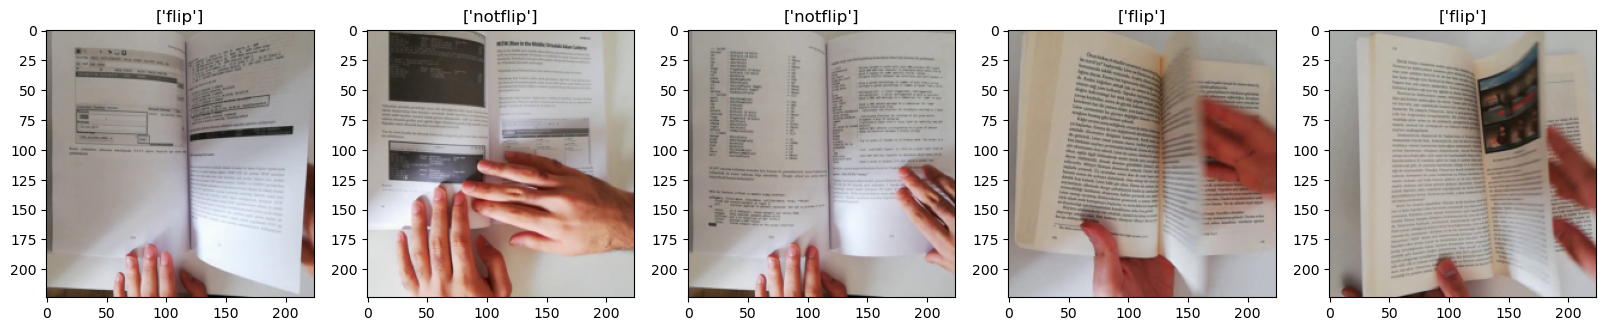

In [15]:
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(inputs[i].permute(1, 2, 0))
    plt.title([d_train.classes[classes[i]]])

Let's create a simple CNN to use for single image prediction.

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            ## block 1
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=(3, 3)),  ## Convo layer

            nn.ReLU(),                      ## ReLU activation function
            nn.MaxPool2d((2, 2)),           ## Pooling layer
            nn.Dropout(p=.1),               ## Dropout layer

            ## block 2
            nn.Conv2d(64, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(p=.1),
            
            ## block 3
            nn.Conv2d(32, 16, (2,2)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=.1),
             
            nn.Flatten(),
            nn.Linear(10816, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,1))

    def forward(self, x):
        out = torch.sigmoid(self.main(x)) ## sigmoid as we will use the BCELoss loss function
        return out

In [17]:
cnn_model = Net()
summary(cnn_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
         MaxPool2d-3         [-1, 64, 111, 111]               0
           Dropout-4         [-1, 64, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]          18,464
              ReLU-6         [-1, 32, 109, 109]               0
         MaxPool2d-7           [-1, 32, 54, 54]               0
           Dropout-8           [-1, 32, 54, 54]               0
            Conv2d-9           [-1, 16, 53, 53]           2,064
             ReLU-10           [-1, 16, 53, 53]               0
        MaxPool2d-11           [-1, 16, 26, 26]               0
          Dropout-12           [-1, 16, 26, 26]               0
          Flatten-13                [-1, 10816]               0
           Linear-14                 [-

#### Defining the Loss and optimization functions
The Binary Cross Entropy and is used as we have a binary classification problem
and Adam as the optimizer

In [18]:
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optim_adam = optim.Adam(cnn_model.parameters(), lr=0.001)

#### Implementing Early Stopping to prevent overfitting
Early stopping is a form of regularization used to avoid overfitting on the training dataset. Early stopping keeps track of the validation loss, if the loss stops decreasing for several epochs in a row till the training stops

In [22]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Train the model.

In [24]:
def train_model(model, criterion, optimizer, trainloader, valloader, epochs=5, patience=2, verbose=True):
    
    train_loss, train_accuracy = [], []
    val_loss = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        val_batch_loss = 0
        

        # Training
        model.train()
        for X, y in trainloader:
            ## reset the gradient
            optimizer.zero_grad()
            ## forward pass
            y_hat = model(X).flatten()
            ## calculate the loss
            loss = criterion(y_hat, y.type(torch.float32))
            ## backpropagation
            loss.backward()
            ## update the weights
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (torch.round(y_hat) == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))
        
        
        # Validation
        model.eval()
        for data, target in valloader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).flatten()
            # calculate the loss
            loss = criterion(output, target.type(torch.float32))
            val_batch_loss += loss.item()

        ## record validation loss
        val_loss.append(val_batch_loss / len(valloader))
        

        ## Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Validation Loss: {val_loss[-1]:.3f}")
            
        
        ## early_stopping needs the validation loss to check if it has decresed, 
        ## and if it has, it will make a checkpoint of the current model
        val_loss_arr = np.average(val_loss)
        early_stopping(val_loss_arr, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

       
    results = {"train_loss": train_loss,
               "train_accuracy": train_accuracy,
               "val_loss": val_loss}
   
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return results, train_loss, train_accuracy, val_loss

In [25]:
results, train_loss, train_accuracy, val_loss = train_model(cnn_model, criterion, optim_adam, dl_train, dl_valid, epochs=20)

Epoch 1: Train Loss: 0.693 Train Accuracy: 0.51 Validation Loss: 0.691
Validation loss decreased (inf --> 0.691386).  Saving model ...
Epoch 2: Train Loss: 0.596 Train Accuracy: 0.66 Validation Loss: 0.579
Validation loss decreased (0.691386 --> 0.635371).  Saving model ...
Epoch 3: Train Loss: 0.314 Train Accuracy: 0.86 Validation Loss: 0.279
Validation loss decreased (0.635371 --> 0.516590).  Saving model ...
Epoch 4: Train Loss: 0.135 Train Accuracy: 0.95 Validation Loss: 0.098
Validation loss decreased (0.516590 --> 0.411987).  Saving model ...
Epoch 5: Train Loss: 0.086 Train Accuracy: 0.97 Validation Loss: 0.122
Validation loss decreased (0.411987 --> 0.353894).  Saving model ...
Epoch 6: Train Loss: 0.043 Train Accuracy: 0.98 Validation Loss: 0.090
Validation loss decreased (0.353894 --> 0.309906).  Saving model ...
Epoch 7: Train Loss: 0.023 Train Accuracy: 0.99 Validation Loss: 0.076
Validation loss decreased (0.309906 --> 0.276479).  Saving model ...
Epoch 8: Train Loss: 0.04

In [30]:
#save the model
#torch.save(cnn_model.state_dict(), "C:\\Users\\Dorcas Taiwo\\Documents\\AI_Residency_Projects\\Project4\\sYK4raA4xabgaLi9\\models\\cnnmodel.ckpt")

In [31]:
## load the model
cnn_model.load_state_dict(torch.load("C:\\Users\\Dorcas Taiwo\\Documents\\AI_Residency_Projects\\Project4\\sYK4raA4xabgaLi9\\models\\cnnmodel.ckpt"))

<All keys matched successfully>

Test the model.

In [32]:
def test_model(model, criterion, testloader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in testloader:
      out = model(X).flatten()
      test_loss += criterion(out, y.type(torch.float32))
      correct += torch.round(out).eq(y).sum()
    
    test_loss /= len(testloader)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader),
            100. * correct / len(testloader)))

In [33]:
test_model(cnn_model, criterion, dl_test)


Test set: Avg. loss: 0.0328, Accuracy: 592/597 (99%)



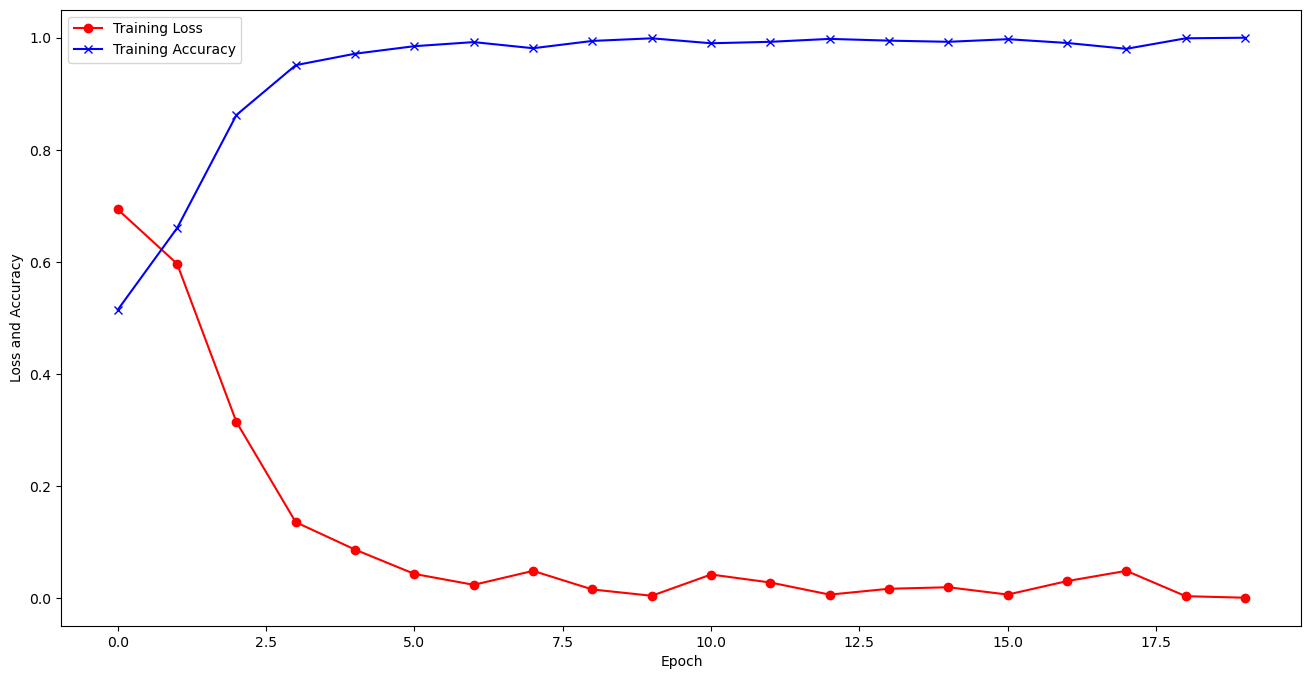

In [34]:
## save the training loss and accuracy
np.save('train_loss.npy', np.array(train_loss))
np.save('train_accuracy.npy', np.array(train_accuracy))

## load the training loss and accuracy
train_loss = np.load('train_loss.npy')
train_accuracy = np.load('train_accuracy.npy')

## plot the training loss and accuracy
plt.figure(figsize=(16,8))
plt.plot(train_loss,color="r",marker="o")
plt.plot(train_accuracy, color='b', marker='x')

plt.xlabel("Epoch")
plt.ylabel("Loss and Accuracy")
plt.legend(["Training Loss", "Training Accuracy"])
plt.show()

In [35]:
dl_test_ = DataLoader(dataset=d_test,
                      batch_size=1)

def test_model_batch_size1(model, criterion, testloader):
  model.eval()
  test_loss, correct = 0, 0
  pred_list, true_list = [], []

  with torch.no_grad():
    for X, y in testloader:
      out = model(X).flatten()
      test_loss += criterion(out, y.type(torch.float32))
      correct += torch.round(out).eq(y.type(torch.float32)).sum()
      pred_list.append(torch.round(out))
      true_list.append(y.type(torch.float32))
      
    test_loss /= len(testloader)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader),
            100. * correct / len(testloader)))
    
  return pred_list, true_list

In [36]:
predictions, labels = test_model_batch_size1(cnn_model, criterion, dl_test_)


Test set: Avg. loss: 0.0328, Accuracy: 592/597 (99%)



In [37]:
predictions, labels = test_model_batch_size1(cnn_model, criterion, dl_test_)
print(classification_report([i.item() for i in predictions], [i.item() for i in labels]))


Test set: Avg. loss: 0.0328, Accuracy: 592/597 (99%)

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       285
         1.0       1.00      0.98      0.99       312

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



The model achieved a 99% F1-score.